# E-Commerce EDA — Simplified Notebook

This simplified notebook contains the same sections and outcomes as the previous version,
but uses **easy-to-read code** and **line-by-line comments** so students can follow quickly.

Sections: Load → Clean → Univariate → Bivariate → Multivariate → Segments → Derived metrics → Time-series → Save

Each code cell contains short comments explaining what each variable/line does.

## 0. Imports & plotting settings

**Why:** Load standard libraries and set a clean plotting style.

In [1]:

# Basic imports
import pandas as pd              # for data manipulation (tables)
import numpy as np               # for numeric operations
import matplotlib.pyplot as plt  # for plotting charts
import os                        # for file path checks

# Make charts look clean and readable
plt.style.use('ggplot')          # a simple, presentation-friendly style
plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.size'] = 11

# Paths for the dataset and cleaned output
DATA_PATH = "Realistic_E-Commerce_Dataset.csv"

print("Ready. DATA_PATH:", DATA_PATH)


Ready. DATA_PATH: Realistic_E-Commerce_Dataset.csv


## 1. Load dataset

**Why:** Confirm file exists and inspect first rows to form hypotheses.

**Outcome:** Know dataset shape and column names.

In [2]:

# Check the file exists
# if not os.path.exists(DATA_PATH):
#     raise FileNotFoundError(f"Please upload the CSV to {DATA_PATH}")

# Read CSV into a pandas DataFrame
df = pd.read_csv(DATA_PATH)

# Print shape (#rows, #columns) and show first 5 rows
print('Shape:', df.shape)   # number of rows and columns
print('\nColumns:', list(df.columns))  # list of column names
display(df.head())          # show first 5 rows for a quick look


Shape: (1200, 25)

Columns: ['user_id', 'session_id', 'date', 'gender', 'age', 'location', 'membership_status', 'returning_customer', 'device_type', 'browser', 'time_of_day', 'time_spent_minutes', 'pages_viewed', 'scroll_depth', 'clicks', 'traffic_source', 'ad_campaign', 'coupon_used', 'discount_applied', 'product_category', 'wishlist_items', 'cart_items', 'avg_session_value', 'payment_method', 'purchase']


,user_id,session_id,date,gender,age,location,membership_status,returning_customer,device_type,browser,...,traffic_source,ad_campaign,coupon_used,discount_applied,product_category,wishlist_items,cart_items,avg_session_value,payment_method,purchase
0,1,4174,2023-01-01 00:00:00,Female,45,Australia,Registered,0,Mobile,Edge,...,Referral,Campaign_B,0,0,Sports,4,2,345.40,COD,1
1,2,4507,2023-01-01 01:00:00,Male,34,USA,Guest,0,Mobile,Edge,...,Social,Campaign_C,0,1,Books,9,1,286.72,Debit Card,1
2,3,1860,2023-01-01 02:00:00,Male,48,Canada,Guest,0,Mobile,Safari,...,Organic,Campaign_C,0,0,Electronics,6,2,190.42,UPI,1
3,4,2294,2023-01-01 03:00:00,Female,25,Germany,Registered,0,Desktop,Edge,...,Social,Campaign_B,0,1,Home,7,7,328.79,UPI,1
4,5,2130,2023-01-01 04:00:00,Female,57,UK,Registered,0,Desktop,Chrome,...,Social,Campaign_A,1,0,Clothing,7,1,85.97,NetBanking,1


## 2. Quick summary & missing values

**Why:** See basic statistics and missing counts to guide cleaning.

**Outcome:** Decide imputation and type fixes.

In [ ]:

# Basic numeric summary
numeric = df.select_dtypes(include=[np.number])
print('Numeric columns summary:')
display(numeric.describe().T)   # mean, std, min, max for numeric features

# Missing values per column
print('\nMissing values per column:')
missing = df.isna().sum().sort_values(ascending=False)
display(missing.head(30))


## 3. Clean types and parse dates

**Why:** Convert columns to correct types, especially `date` for time analysis.

**Outcome:** Ready for feature engineering.

In [ ]:

# Parse 'date' column to datetime so we can extract hour/day later
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')  # convert strings to datetime; invalid -> NaT

# Convert integer-like columns safely (preserve NA)
int_cols = ['user_id','session_id','age','time_spent_minutes','pages_viewed','scroll_depth','clicks','wishlist_items','cart_items']
for col in int_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # non-numeric -> NaN

# Show dtypes after conversion
print('Dtypes after conversions:')
print(df.dtypes.head(15))


## 4. (Optional) Inject a few missing values for demo

**Why:** If dataset has no missing values, create a few for imputation.

**Outcome:** A few controlled missing values to practice filling.

In [4]:

# Only inject if data has zero missing values (keeps original data otherwise)
if df.isna().sum().sum() == 0:
    rng = np.random.default_rng(1)
    idx = rng.choice(df.index, size=6, replace=False)
    # Make some ages missing
    if 'age' in df.columns:
        df.loc[idx[:2], 'age'] = np.nan
    # Make time_spent_minutes missing
    if 'time_spent_minutes' in df.columns:
        df.loc[idx[2:4], 'time_spent_minutes'] = np.nan
    # Make product_category missing
    if 'product_category' in df.columns:
        df.loc[idx[4:], 'product_category'] = np.nan
    print('Injected missing at indices:', list(idx))
else:
    print('Dataset already has missing values; no injection done.')

# Show missing summary
display(df.isna().sum().sort_values(ascending=False).head(10))


Dataset already has missing values; no injection done.


ad_campaign          459
user_id                0
scroll_depth           0
payment_method         0
avg_session_value      0
cart_items             0
wishlist_items         0
product_category       0
discount_applied       0
coupon_used            0
dtype: int64

## 5. Imputation (simple and explainable)

**Why:** Fill missing values so plots and models run without errors. We'll use median for numbers and 'Unknown' for categories.

**Outcome:** Cleaned columns ready for analysis.

In [5]:

# Fill numeric missing values with median (explainable and robust to outliers)
for col in ['age','time_spent_minutes']:
    if col in df.columns:
        median = df[col].median(skipna=True)
        df[col] = df[col].fillna(median)
        print(f'Filled {col} missing with median =', median)

# Fill categorical missing with 'Unknown' so they become a category
if 'product_category' in df.columns:
    df['product_category'] = df['product_category'].fillna('Unknown')
    print('Filled product_category missing with Unknown')

# Quick check
display(df.isna().sum().sort_values(ascending=False).head(10))


Filled age missing with median = 41.0
Filled time_spent_minutes missing with median = 29.0
Filled product_category missing with Unknown


ad_campaign          459
user_id                0
scroll_depth           0
payment_method         0
avg_session_value      0
cart_items             0
wishlist_items         0
product_category       0
discount_applied       0
coupon_used            0
dtype: int64

## 6. Derived features (simple and useful)

**Why:** These features help capture behavior and time patterns. Each line is commented.

**Outcome:** New, interpretable features for EDA and later modeling.

In [ ]:
# Extract day of week and hour from the timestamp
if 'date' in df.columns:
    # Use the .dt accessor to access datetime properties
    df['day_of_week'] = df['date'].dt.day_name()   # Monday, Tuesday, ...
    df['hour'] = df['date'].dt.hour               # 0-23 hour of the day
else:
    df['day_of_week'] = 'Unknown'
    df['hour'] = 0

# Age groups: simple bins
df['age_group'] = pd.cut(df['age'], bins=[17,25,40,65], labels=['18-25','26-40','41-65'])

# cart_to_wishlist_ratio: intent measure (cart items divided by wishlist size)
df['cart_to_wishlist_ratio'] = df.apply(lambda r: (r['cart_items'] / r['wishlist_items']) if (r.get('wishlist_items',0) and r['wishlist_items']>0) else r['cart_items'], axis=1)

# engagement_score: small composite metric from time, pages, clicks (weights are chosen for simplicity)
df['engagement_score'] = (df['time_spent_minutes']/60)*0.4 + (df['pages_viewed']/20)*0.35 + (df['clicks']/50)*0.25

# value_per_cart_item: avg session value divided by cart items (fallback to avg if cart is zero)
df['value_per_cart_item'] = df.apply(lambda r: (r['avg_session_value']/r['cart_items']) if (r.get('cart_items',0) and r['cart_items']>0) else r['avg_session_value'], axis=1)

# Show a few rows with derived columns
display(df[['date','age','age_group','hour','cart_items','wishlist_items','cart_to_wishlist_ratio','engagement_score','value_per_cart_item']].head())

AttributeError: 'Series' object has no attribute 'day_name'

## 7. Univariate EDA — Numeric features (simple plots)

**Why:** See the shape of numeric features. We annotate mean and median for clarity.

**Outcome:** Students can spot skew and outliers.

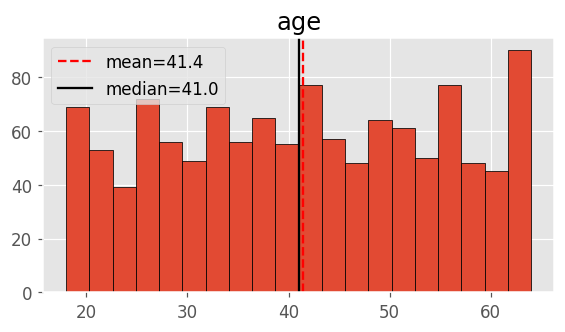

age -> mean: 41.40, median: 41.00, missing: 0



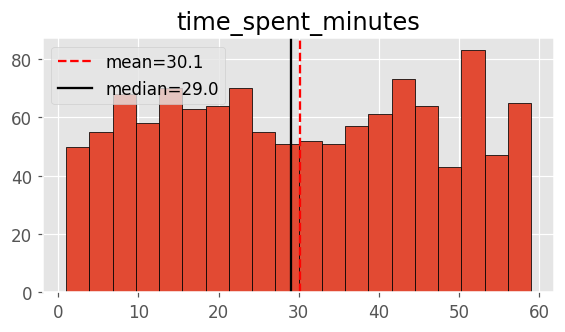

time_spent_minutes -> mean: 30.14, median: 29.00, missing: 0



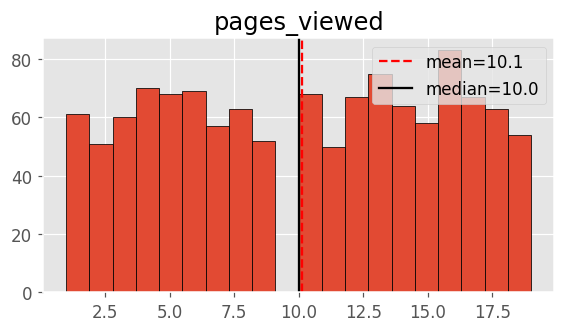

pages_viewed -> mean: 10.12, median: 10.00, missing: 0



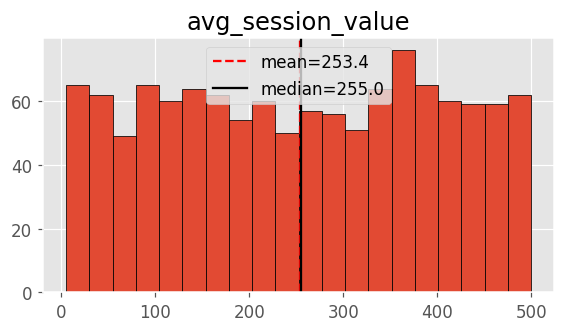

avg_session_value -> mean: 253.40, median: 254.97, missing: 0



In [8]:

num_cols = ['age','time_spent_minutes','pages_viewed','avg_session_value','engagement_score','value_per_cart_item']

for col in num_cols:
    if col in df.columns:
        data = df[col].dropna()
        plt.figure(figsize=(6,3))
        plt.hist(data, bins=20, edgecolor='black')
        plt.title(col)
        # show mean and median lines
        plt.axvline(data.mean(), color='red', linestyle='--', label=f'mean={data.mean():.1f}')
        plt.axvline(data.median(), color='black', linestyle='-', label=f'median={data.median():.1f}')
        plt.legend()
        plt.show()
        # print short outcome
        print(f"{col} -> mean: {data.mean():.2f}, median: {data.median():.2f}, missing: {data.isna().sum()}\n")


## 8. Univariate EDA — Categorical features (counts)

**Why:** Identify dominant categories which affect encoding and sampling.

**Outcome:** We list top categories for each column.

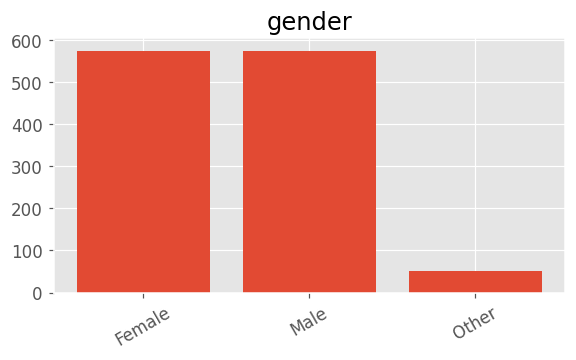

gender top 3: ['Female', 'Male', 'Other'] -> counts [np.int64(575), np.int64(575), np.int64(50)]



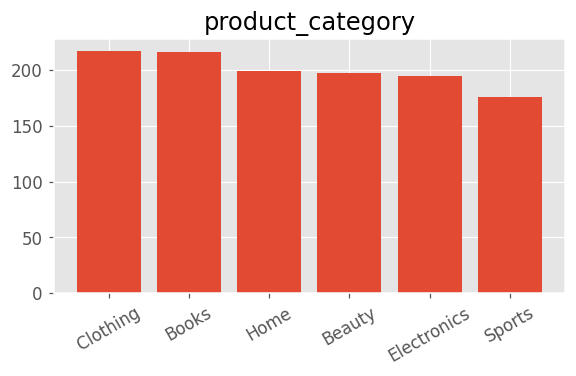

product_category top 3: ['Clothing', 'Books', 'Home'] -> counts [np.int64(217), np.int64(216), np.int64(199)]



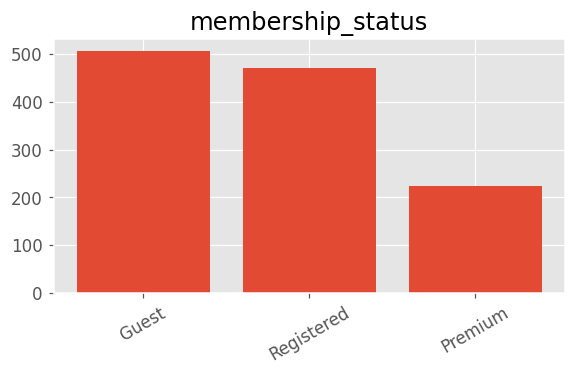

membership_status top 3: ['Guest', 'Registered', 'Premium'] -> counts [np.int64(506), np.int64(470), np.int64(224)]



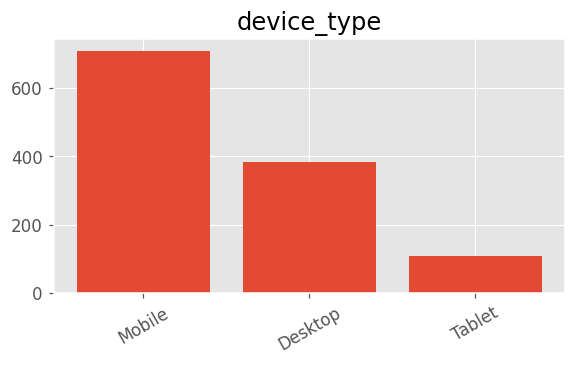

device_type top 3: ['Mobile', 'Desktop', 'Tablet'] -> counts [np.int64(708), np.int64(383), np.int64(109)]



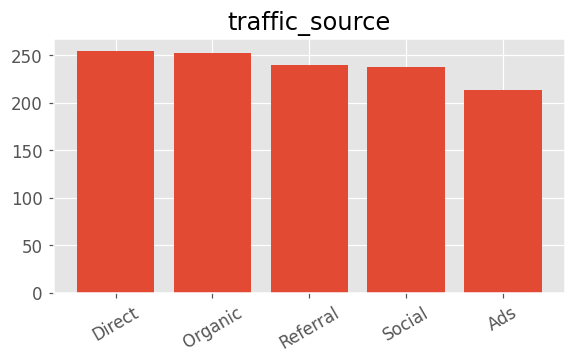

traffic_source top 3: ['Direct', 'Organic', 'Referral'] -> counts [np.int64(255), np.int64(253), np.int64(240)]



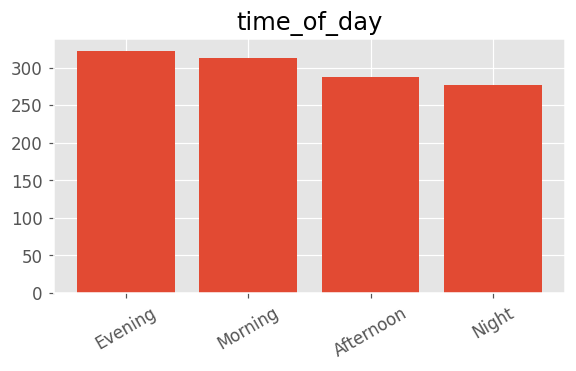

time_of_day top 3: ['Evening', 'Morning', 'Afternoon'] -> counts [np.int64(322), np.int64(313), np.int64(288)]



In [9]:

cat_cols = ['gender','product_category','membership_status','device_type','traffic_source','time_of_day']

for col in cat_cols:
    if col in df.columns:
        counts = df[col].value_counts()
        plt.figure(figsize=(6,3))
        plt.bar(counts.index.astype(str), counts.values)
        plt.title(col)
        plt.xticks(rotation=30)
        plt.show()
        print(f"{col} top 3: {list(counts.head(3).index)} -> counts {list(counts.head(3).values)}\n")


## 9. Target variable `purchase` (balance)

**Why:** Check how balanced the target is; influences modeling choices.

**Outcome:** Observe purchase percentage.

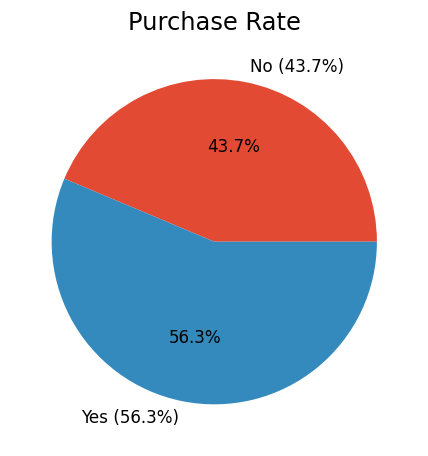

Purchase rate = 0.563


In [10]:
# Check if the DataFrame has a column named 'purchase'
# Calculate purchase rate (mean works since values are 0/1 → fraction of 1s)
rate = df['purchase'].mean()
    
    # Create a pie chart showing Yes vs No purchases
plt.pie(
        [1 - rate, rate],                          # proportions: No vs Yes
        labels=[f'No ({1-rate:.1%})', f'Yes ({rate:.1%})'],  # labels with percentages
        autopct='%1.1f%%'                          # show percentages inside the pie
)
    
    # Add chart title
plt.title('Purchase Rate')
    
    # Display the chart
plt.show()
    
    # Print purchase rate rounded to 3 decimal places
print(f'Purchase rate = {rate:.3f}')

## 10. Bivariate — Numeric vs purchase (boxplots)

**Why:** Check whether numeric features differ for purchasers vs non-purchasers.

**Outcome:** Compare medians; higher median often means the feature is predictive.

/var/folders/v5/2xv9352947zbqtzrjyrby08c0000gn/T/ipykernel_6256/1866865176.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([no, yes], labels=['No','Yes'])


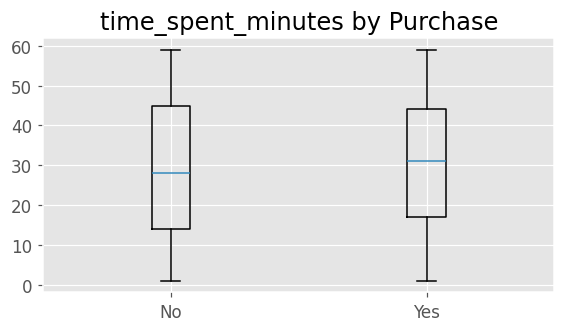

time_spent_minutes medians -> No: 28.00, Yes: 31.00



/var/folders/v5/2xv9352947zbqtzrjyrby08c0000gn/T/ipykernel_6256/1866865176.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([no, yes], labels=['No','Yes'])


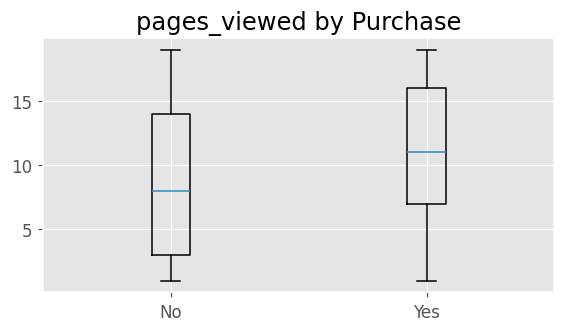

pages_viewed medians -> No: 8.00, Yes: 11.00



In [11]:

cols = ['time_spent_minutes','pages_viewed','engagement_score','value_per_cart_item']

for col in cols:
    if col in df.columns and 'purchase' in df.columns:
        no = df[df['purchase']==0][col].dropna()
        yes = df[df['purchase']==1][col].dropna()
        plt.figure(figsize=(6,3))
        plt.boxplot([no, yes], labels=['No','Yes'])
        plt.title(f'{col} by Purchase')
        plt.show()
        print(f'{col} medians -> No: {no.median():.2f}, Yes: {yes.median():.2f}\n')


## 11. Bivariate — Categorical vs purchase (conversion rates)

**Why:** Find top converting categories to prioritize targeting.

**Outcome:** List top converters for each categorical column.

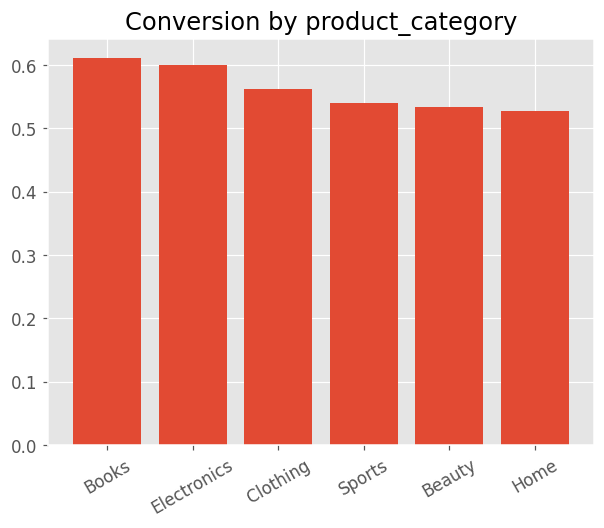

Top converters in product_category: {'Books': 0.611, 'Electronics': 0.6, 'Clothing': 0.562} 



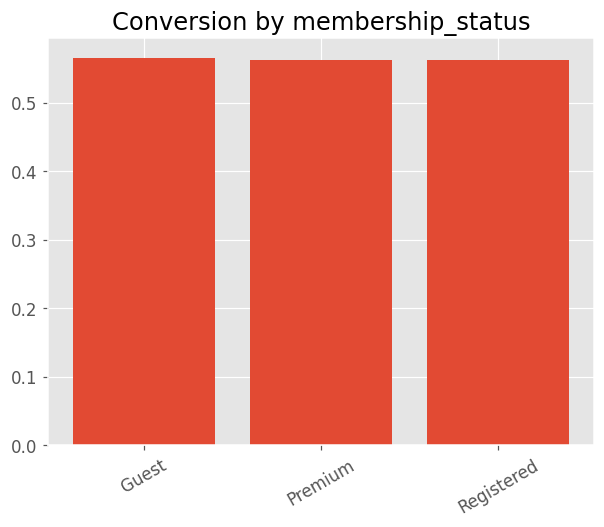

Top converters in membership_status: {'Guest': 0.565, 'Premium': 0.562, 'Registered': 0.562} 



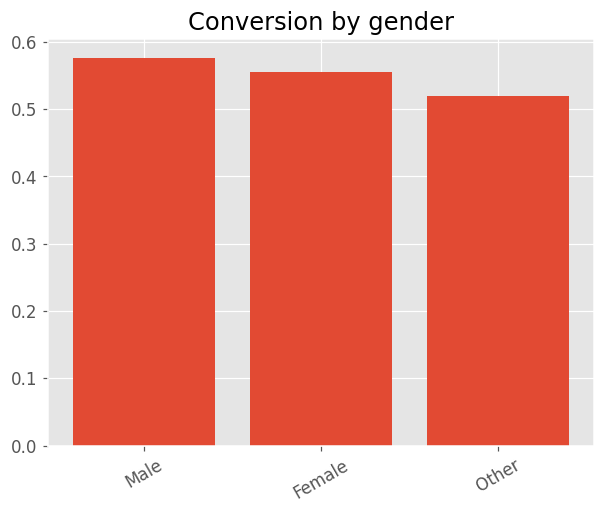

Top converters in gender: {'Male': 0.576, 'Female': 0.555, 'Other': 0.52} 



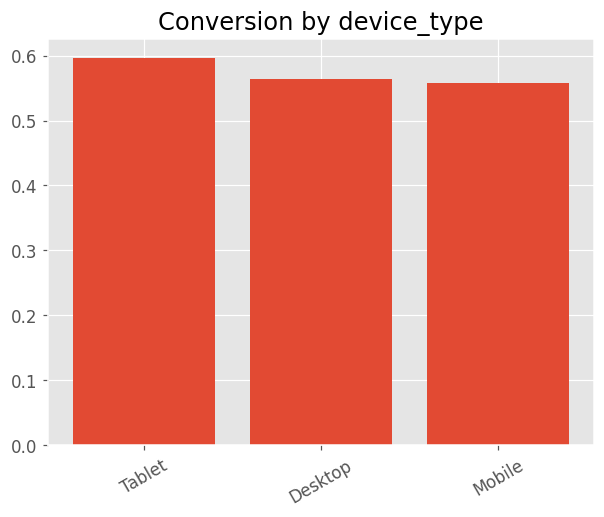

Top converters in device_type: {'Tablet': 0.596, 'Desktop': 0.564, 'Mobile': 0.558} 



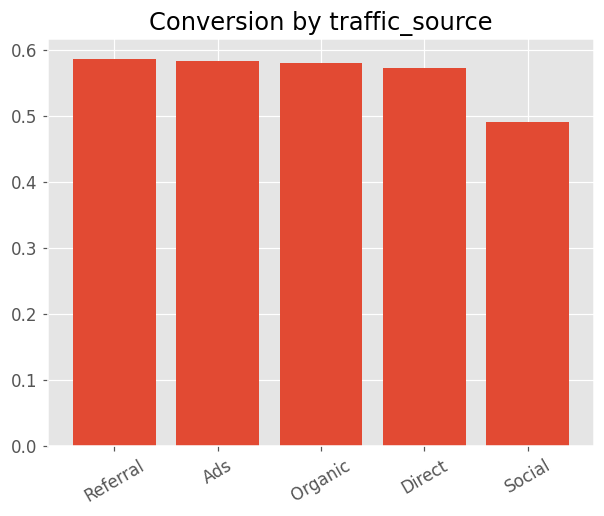

Top converters in traffic_source: {'Referral': 0.588, 'Ads': 0.584, 'Organic': 0.581} 



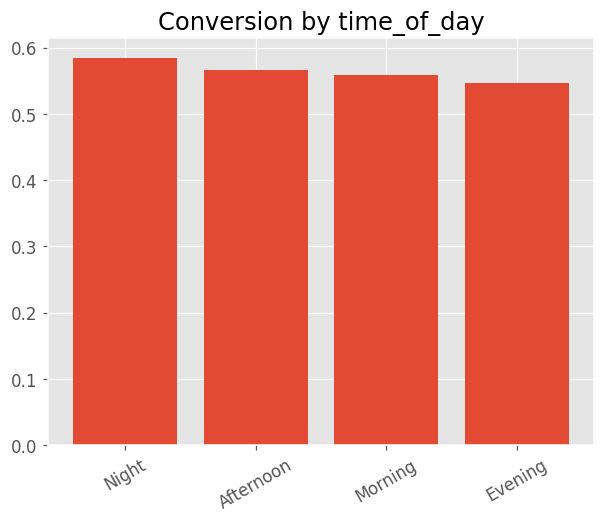

Top converters in time_of_day: {'Night': 0.585, 'Afternoon': 0.566, 'Morning': 0.559} 



In [12]:

cat_list = ['product_category','membership_status','gender','device_type','traffic_source','time_of_day']

for col in cat_list:
    if col in df.columns and 'purchase' in df.columns:
        conv = df.groupby(col)['purchase'].mean().sort_values(ascending=False)
        
        # Plot a bar chart
        plt.bar(conv.index.astype(str), conv.values)
        plt.title(f'Conversion by {col}')
        plt.xticks(rotation=30)
        plt.show()
        
        # Print top 3 converters
        print(f'Top converters in {col}:', conv.head(3).round(3).to_dict(), '\n')


## 12. Multivariate — Correlation matrix

**Why:** See which numeric features are correlated. Helps avoid multicollinearity.

**Outcome:** Table and heatmap of correlations.

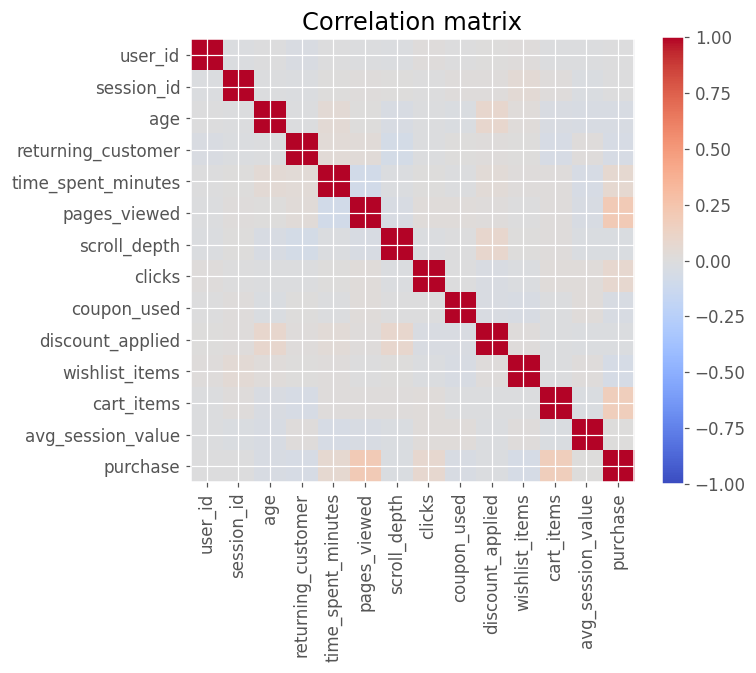

,f1,f2,abs_corr
0,pages_viewed,purchase,0.199654
1,purchase,cart_items,0.167953
2,pages_viewed,time_spent_minutes,0.083491
3,discount_applied,age,0.079906
4,discount_applied,scroll_depth,0.079310
5,clicks,purchase,0.075587
6,time_spent_minutes,purchase,0.068544
7,returning_customer,scroll_depth,0.063199


In [14]:

# Numeric correlations
num = df.select_dtypes(include=[np.number]).copy()
corr = num.corr()
plt.figure(figsize=(7,6))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title('Correlation matrix')
plt.tight_layout()
plt.show()

# Print top correlated pairs (absolute value)
pairs = corr.abs().unstack().sort_values(ascending=False)
pairs = pairs[pairs < 0.9999]  # remove self-correlation
top = pairs.drop_duplicates().head(8)
display(top.reset_index().rename(columns={'level_0':'f1','level_1':'f2',0:'abs_corr'}))


## 13. Pairwise scatter (sample)

**Why:** Quick visual check for relationships; sample rows to keep plots readable.

**Outcome:** Spot obvious clusters or trends.

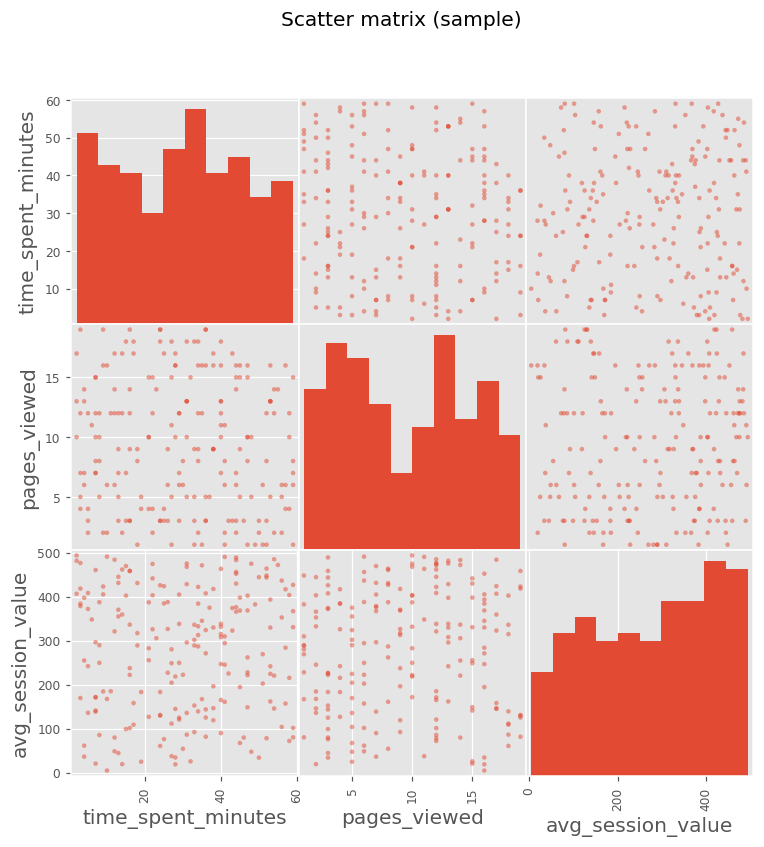

In [15]:

sample_cols = ['time_spent_minutes','pages_viewed','avg_session_value','engagement_score']
available = [c for c in sample_cols if c in df.columns]
if len(available) >= 2:
    sample = df[available].sample(n=min(200, len(df)), random_state=2)
    pd.plotting.scatter_matrix(sample, diagonal='hist', figsize=(8,8))
    plt.suptitle('Scatter matrix (sample)')
    plt.show()
else:
    print('Not enough columns for scatter matrix.')


## 14. Segmented analysis — pivot & grouped view

**Why:** Look at combinations like membership × product to prioritize segments.

**Outcome:** Pivot table and a small bar chart.

product_category,Beauty,Books,Clothing,Electronics,Home,Sports
membership_status,,,,,,
Guest,0.474,0.614,0.590,0.621,0.567,0.492
Premium,0.551,0.564,0.667,0.545,0.548,0.513
Registered,0.586,0.628,0.481,0.600,0.474,0.595


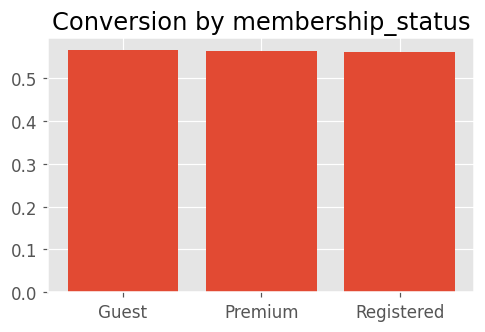

In [16]:

# Pivot: membership_status x product_category conversion
if 'membership_status' in df.columns and 'product_category' in df.columns:
    pivot = df.pivot_table(index='membership_status', columns='product_category', values='purchase', aggfunc='mean')
    display(pivot.round(3))
    # Plot membership conversion overall
    mem = df.groupby('membership_status')['purchase'].mean()
    plt.figure(figsize=(5,3))
    plt.bar(mem.index, mem.values)
    plt.title('Conversion by membership_status')
    plt.show()
    


## 15. Derived metrics — check usefulness

**Why:** See whether engagement_score and cart_to_wishlist_ratio separate purchasers.

**Outcome:** Boxplots and medians.

In [18]:

if 'engagement_score' in df.columns and 'purchase' in df.columns:
    plt.figure(figsize=(6,3))
    plt.boxplot([df[df['purchase']==0]['engagement_score'], df[df['purchase']==1]['engagement_score']], labels=['No','Yes'])
    plt.title('Engagement score by purchase')
    plt.show()
    print('engagement_score medians ->', df.groupby('purchase')['engagement_score'].median().to_dict())

if 'cart_to_wishlist_ratio' in df.columns and 'purchase' in df.columns:
    plt.figure(figsize=(6,3))
    plt.boxplot([df[df['purchase']==0]['cart_to_wishlist_ratio'], df[df['purchase']==1]['cart_to_wishlist_ratio']], labels=['No','Yes'])
    plt.title('Cart-to-wishlist ratio by purchase')
    plt.show()


## 16. Time-series — daily & hourly patterns

**Why:** Find times/days with higher conversion; helpful for scheduling campaigns.

**Outcome:** Line plots of daily purchase rate and hourly conversion.

In [ ]:

if 'date' in df.columns and 'purchase' in df.columns:
    df['date_only'] = df['date'].dt.date
    daily = df.groupby('date_only').agg(total=('purchase','count'), purchases=('purchase','sum'))
    daily['rate'] = daily['purchases'] / daily['total']

    plt.figure(figsize=(9,3))
    plt.plot(daily.index, daily['rate'], marker='o')
    plt.title('Daily purchase rate')
    plt.xticks(rotation=45)
    plt.show()

    # Hourly conversion
    hourly = df.groupby('hour')['purchase'].mean()
    plt.figure(figsize=(7,3))
    plt.plot(hourly.index, hourly.values, marker='o')
    plt.title('Hourly purchase rate')
    plt.show()
else:
    print('Missing date or purchase column.')


## 17. Summary & next steps

**Summary:**
- The notebook is simplified for student consumption.
- Key signals: engagement, pages viewed, cart behavior, membership.

**Next steps:** Build preprocessing pipeline, train baseline models, evaluate with business-driven metrics, deploy a prediction API.